In [1]:
import numpy as np
import torch


In [2]:
# Local utilities
from utils import (
    load_data,
    plot_true_vs_pred,
    compute_effect,
    compute_metric,
)
from simulation import (
    simulate_treatment,
    compute_outcome,
)
from interference import run_gcn_experiment
from propensity import run_propensity_experiment
from mean import run_mean_experiment

In [3]:
# Data_path "Flickr_New.npz" or "BC_New.npz"
path="Flickr_New.npz"
# Feature name lda_10, lda_5, pca_10, pca_5, lda_supervised
feature_name="lda_supervised"
# Fold number 0,1,2,3,4
fold_num=2
X,adj_matrix,X_val,adj_matrix_val,X_test,adj_matrix_test=load_data(path,feature_name,fold_num)

In [4]:
# Larger, propensity score more extreme to 0 or 1
beta=1
# Larger, propensity score shift to 1
alpha=2
# Larger, more weight on larger attention
sparse_param=5
# Noise level
sigma=0.05
# Larger, higher spillover effect/base effect
scale=5
# Attention type "cosine" or "rbf" or "homo" or "heter"
attention_type="cosine"
# Num of num_partitions
num_partition=3
# Train
one_hop_neighbors, n, d, partitions, treat_binary, e_star, treat_neighbor, treat_matrix=simulate_treatment(X, adj_matrix, mode="train",beta=beta, alpha=alpha,num_partitions=num_partition)
true_attention, spillover, U_0, noise, y, m_star =\
 compute_outcome(X, adj_matrix, treat_matrix, e_star, n, sigma, scale, sparse_param,attention_type)
IME, ISE, ITE = compute_effect(true_attention, adj_matrix)

# Test
one_hop_neighbors_test, n_test, d_test, partitions_test, treat_binary_test, e_star_test, treat_neighbor_test, treat_matrix_test=\
  simulate_treatment(X_test, adj_matrix_test,mode="test",beta=beta, alpha=alpha)
true_attention_test, spillover_test, U_0_test, noise_test, y_test, m_star_test =\
 compute_outcome(X_test, adj_matrix_test, treat_matrix_test, e_star_test, n_test, sigma, scale, sparse_param,attention_type)
IME_test, ISE_test, ITE_test = compute_effect(true_attention_test, adj_matrix_test)

In [5]:
# Setting hyperparmeters
propensity_params = {"hidden_dim": 128, "lr": 0.001, "epochs": 100}
mean_params = {"hidden_dim": 128, "lr": 0.001, "epochs": 100}

ehat,propensity_models = run_propensity_experiment(X, adj_matrix, treat_binary, y, m_star, partitions, propensity_params,print_logs=True,aug=False,device="cpu")
mhat,mean_models = run_mean_experiment(X, adj_matrix, treat_binary, y,
                                       m_star, ehat, partitions, mean_params,
                                       bagging=True, aug=True,
                                       print_logs=True,agg_method='mean',device="cpu")

Partition: 0, epoch: 050 - New best Testing Loss: 0.4378
Partition: 0, epoch: 100 - New best Testing Loss: 0.3947
Partition: 1, epoch: 050 - New best Testing Loss: 0.4606
Partition: 1, epoch: 100 - New best Testing Loss: 0.4265
Partition: 2, epoch: 050 - New best Testing Loss: 0.4470
Partition: 2, epoch: 100 - New best Testing Loss: 0.4085
Partition: 0, epoch: 050 - New best Testing Loss: 0.0176
Partition: 0, epoch: 100 - New best Testing Loss: 0.0105
Partition: 1, epoch: 050 - New best Testing Loss: 0.0230
Partition: 1, epoch: 100 - New best Testing Loss: 0.0104
Partition: 2, epoch: 050 - New best Testing Loss: 0.0141
Partition: 2, epoch: 100 - New best Testing Loss: 0.0077
Improved by bagging


42.574025165740466
31.295017892529742


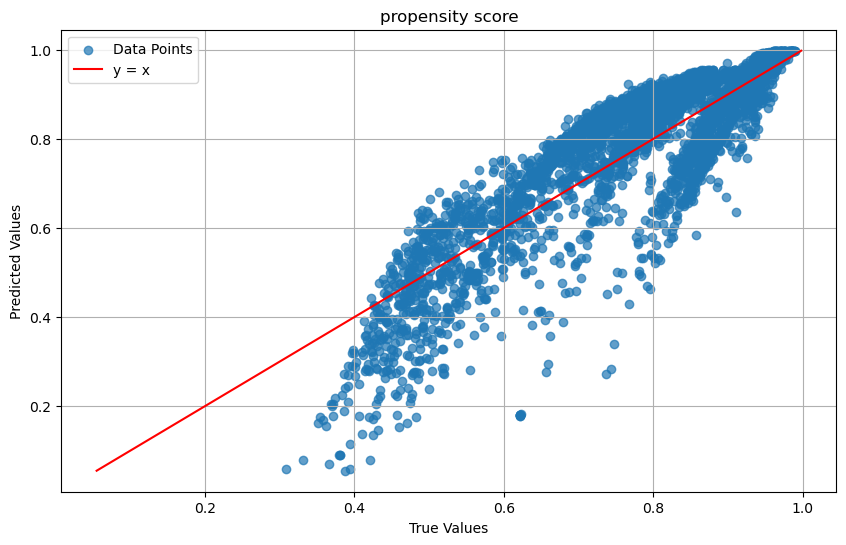

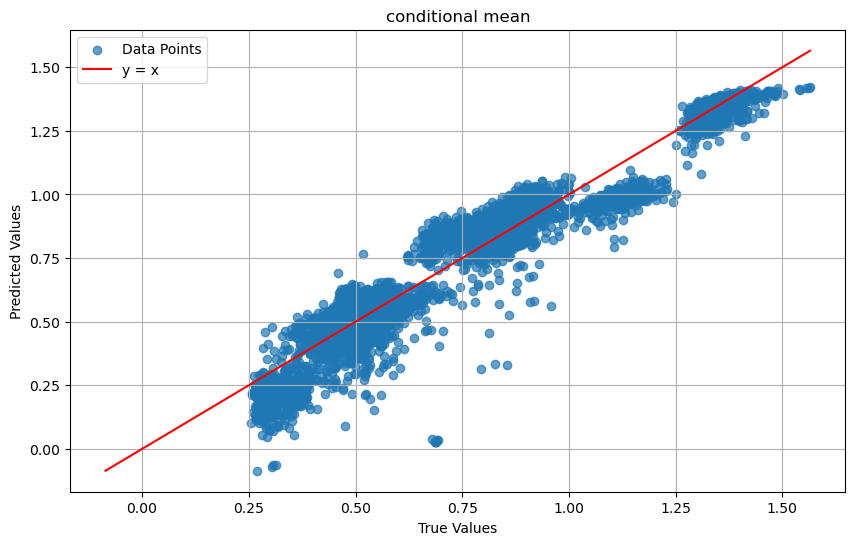

In [18]:
print(np.sum((mhat-m_star)**2))
print(np.sum((ehat-e_star)**2))

plot_true_vs_pred(ehat,e_star,title_name="propensity score")
plot_true_vs_pred(mhat,m_star,title_name="conditional mean")

In [ ]:
hidden_dim=64
spillover_params = {"epochs": 200, "lr": 0.0001, "batch_size": 64, "hidden_dim": hidden_dim}
best_model, best_loss, best_pred_attention = run_gcn_experiment(X, mhat, y, one_hop_neighbors,
                                                                  treat_binary, ehat, true_attention,
                                                                  adj_matrix, sparse_param, spillover_params,
                                                                printing=True, device="cuda")
with torch.no_grad():
  best_predicted_attention,_ = best_model.cpu().predict(torch.tensor(X, dtype=torch.float32), one_hop_neighbors, treat_binary)
IME_est, ISE_est, ITE_est = compute_effect(best_predicted_attention, adj_matrix)
print("Proposed: training set")
Result_train=compute_metric(IME, ISE, ITE, IME_est, ISE_est, ITE_est,printing=True)

with torch.no_grad():
  attention_test,_ = best_model.predict(torch.tensor(X_test, dtype=torch.float32), one_hop_neighbors_test, treat_binary_test)
IME_est_test, ISE_est_test, ITE_est_test = compute_effect(attention_test, adj_matrix_test)
print("Proposed: testing set")
Result_test=compute_metric(IME_test, ISE_test, ITE_test, IME_est_test, ISE_est_test, ITE_est_test,printing=True)

plot_true_vs_pred(ISE,ISE_est,title_name="Hetergenous Flickr, ISE")
plot_true_vs_pred(IME,IME_est,title_name="Hetergenous Flickr, IME")

In [ ]:
print(np.mean(ISE)-np.mean(ISE_est))
# print(np.mean(ISE_est))
print(np.mean(IME_test)-np.mean(IME_est_test))
print(np.mean(ITE)-np.mean(ITE_est))


NameError: name 'ISE_est' is not defined

In [ ]:
adj_matrix

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
import pickle
import torch
from google.colab import files

# ─── Fixed settings ────────────────────────────────────────────────────────────
path            = "BC_New.npz"            # or "BC_New.npz"
feature_name    = "lda_supervised"

beta            = 1      # propensity extremeness
alpha           = 0      # propensity shift
sparse_param    = 5      # attention sparsity weight
sigma           = 0.05   # noise level
scale           = 5      # spillover strength

# fold_nums       = [0, 1, 2, 3, 4]
# attention_types = ["rbf", "cosine"]
# partitions_list = [2, 3, 5, 10]

fold_nums       = [0, 1, 2]
attention_types = ["rbf", "cosine"]
partitions_list = [2, 3, 4, 5, 7, 10,20]

results = {}

for fold in fold_nums:
    # load data fresh for each fold
    X, adj_matrix, X_val, adj_matrix_val, X_test, adj_matrix_test = \
        load_data(path, feature_name, fold)

    for attention in attention_types:
        for num_parts in partitions_list:
            print(f"\n=== Processing Fold {fold} ===\n-- Attention Type: {attention} --\n---- Partitions: {num_parts} ----")


            # Train
            one_hop_neighbors, n, d, partitions, treat_binary, e_star, treat_neighbor, treat_matrix=simulate_treatment(X, adj_matrix, mode="train",beta=beta, alpha=alpha,num_partitions=num_parts)
            true_attention, spillover, U_0, noise, y, m_star =\
            compute_outcome(X, adj_matrix, treat_matrix, e_star, n, sigma, scale, sparse_param,attention)
            IME, ISE, ITE = compute_effect(true_attention, adj_matrix)

            # Test
            one_hop_neighbors_test, n_test, d_test, partitions_test, treat_binary_test, e_star_test, treat_neighbor_test, treat_matrix_test=\
            simulate_treatment(X_test, adj_matrix_test,mode="test",beta=beta, alpha=alpha)
            true_attention_test, spillover_test, U_0_test, noise_test, y_test, m_star_test =\
            compute_outcome(X_test, adj_matrix_test, treat_matrix_test, e_star_test, n_test, sigma, scale, sparse_param,attention)
            IME_test, ISE_test, ITE_test = compute_effect(true_attention_test, adj_matrix_test)


            # Setting hyperparmeters
            propensity_params = {"hidden_dim": 128, "lr": 0.001, "epochs": 1000}
            mean_params = {"hidden_dim": 128, "lr": 0.001, "epochs": 1000}
            spillover_params = {"epochs": 2000, "lr": 0.0001, "batch_size": 64, "hidden_dim": 64}

            ehat,propensity_models = run_propensity_experiment(X, adj_matrix, treat_binary, y, m_star, partitions, propensity_params,print_logs=False,aug=False,device="cuda")
            mhat,mean_models = run_mean_experiment(X, adj_matrix, treat_binary, y,
                                                  m_star, ehat, partitions, mean_params,
                                                  bagging=True, aug=True,
                                                  print_logs=False,agg_method='mean',device="cuda")

            best_model, best_loss, best_pred_attention = run_gcn_experiment(X, mhat, y, one_hop_neighbors,
                                                                              treat_binary, ehat, true_attention,
                                                                              adj_matrix, sparse_param, spillover_params,
                                                                            printing=False, device="cuda")

            # ─── Compute train metrics ────────────────────────────────────
            with torch.no_grad():
              best_predicted_attention,_ = best_model.cpu().predict(torch.tensor(X, dtype=torch.float32), one_hop_neighbors, treat_binary)
            IME_est, ISE_est, ITE_est = compute_effect(best_predicted_attention, adj_matrix)
            Result_train=compute_metric(IME, ISE, ITE, IME_est, ISE_est, ITE_est,printing=False)
            print((np.sum((mhat-m_star)**2),np.sum((ehat-e_star)**2)))
            print(Result_train)
            with torch.no_grad():
              attention_test,_ = best_model.cpu().predict(torch.tensor(X_test, dtype=torch.float32), one_hop_neighbors_test, treat_binary_test)
            IME_est_test, ISE_est_test, ITE_est_test = compute_effect(attention_test, adj_matrix_test)
            Result_test=compute_metric(IME_test, ISE_test, ITE_test, IME_est_test, ISE_est_test, ITE_est_test,printing=False)
            plot_true_vs_pred(ISE,ISE_est,title_name="Hetergenous Flickr, ISE")
            plot_true_vs_pred(IME,IME_est,title_name="Hetergenous Flickr, IME")
            # ─── Store results ────────────────────────────────────────────
            key = f"fold{fold}_{attention}_p{num_parts}"
            results[key] = {
                "Result_train": Result_train,
                "Result_test":  Result_test,
                "m_star, e_star": (np.sum((mhat-m_star)**2),np.sum((ehat-e_star)**2))
            }

# ─── Dump to disk ──────────────────────────────────────────────────────────────
with open("attention_partition_results_BC_alpha0.pkl", "wb") as f:
    pickle.dump(results, f)
files.download("attention_partition_results_BC_alpha0.pkl")
print("\n✔️  All combinations done. Results saved to 'attention_partition_results_BC_alpha0.pkl'")


In [ ]:
path            = "Flickr_New.npz"            # or "BC_New.npz"
feature_name    = "lda_supervised"

beta            = 1      # propensity extremeness
alpha           = 0      # propensity shift
sparse_param    = 5      # attention sparsity weight
sigma           = 0.05   # noise level
scale           = 5      # spillover strength

# fold_nums       = [0, 1, 2, 3, 4]
# attention_types = ["rbf", "cosine"]
# partitions_list = [2, 3, 5, 10]

fold_nums       = [0, 1, 2]
attention_types = ["rbf", "cosine"]
partitions_list = [2, 3, 4, 5, 7, 10,20]

results = {}

for fold in fold_nums:
    # load data fresh for each fold
    X, adj_matrix, X_val, adj_matrix_val, X_test, adj_matrix_test = \
        load_data(path, feature_name, fold)

    for attention in attention_types:
        for num_parts in partitions_list:
            print(f"\n=== Processing Fold {fold} ===\n-- Attention Type: {attention} --\n---- Partitions: {num_parts} ----")


            # Train
            one_hop_neighbors, n, d, partitions, treat_binary, e_star, treat_neighbor, treat_matrix=simulate_treatment(X, adj_matrix, mode="train",beta=beta, alpha=alpha,num_partitions=num_parts)
            true_attention, spillover, U_0, noise, y, m_star =\
            compute_outcome(X, adj_matrix, treat_matrix, e_star, n, sigma, scale, sparse_param,attention)
            IME, ISE, ITE = compute_effect(true_attention, adj_matrix)

            # Test
            one_hop_neighbors_test, n_test, d_test, partitions_test, treat_binary_test, e_star_test, treat_neighbor_test, treat_matrix_test=\
            simulate_treatment(X_test, adj_matrix_test,mode="test",beta=beta, alpha=alpha)
            true_attention_test, spillover_test, U_0_test, noise_test, y_test, m_star_test =\
            compute_outcome(X_test, adj_matrix_test, treat_matrix_test, e_star_test, n_test, sigma, scale, sparse_param,attention)
            IME_test, ISE_test, ITE_test = compute_effect(true_attention_test, adj_matrix_test)


            # Setting hyperparmeters
            propensity_params = {"hidden_dim": 128, "lr": 0.001, "epochs": 1000}
            mean_params = {"hidden_dim": 128, "lr": 0.001, "epochs": 1000}
            spillover_params = {"epochs": 2000, "lr": 0.0001, "batch_size": 64, "hidden_dim": 64}

            ehat,propensity_models = run_propensity_experiment(X, adj_matrix, treat_binary, y, m_star, partitions, propensity_params,print_logs=False,aug=False,device="cuda")
            mhat,mean_models = run_mean_experiment(X, adj_matrix, treat_binary, y,
                                                  m_star, ehat, partitions, mean_params,
                                                  bagging=True, aug=True,
                                                  print_logs=False,agg_method='mean',device="cuda")

            best_model, best_loss, best_pred_attention = run_gcn_experiment(X, mhat, y, one_hop_neighbors,
                                                                              treat_binary, ehat, true_attention,
                                                                              adj_matrix, sparse_param, spillover_params,
                                                                            printing=False, device="cuda")

            # ─── Compute train metrics ────────────────────────────────────
            with torch.no_grad():
              best_predicted_attention,_ = best_model.cpu().predict(torch.tensor(X, dtype=torch.float32), one_hop_neighbors, treat_binary)
            IME_est, ISE_est, ITE_est = compute_effect(best_predicted_attention, adj_matrix)
            Result_train=compute_metric(IME, ISE, ITE, IME_est, ISE_est, ITE_est,printing=False)
            print((np.sum((mhat-m_star)**2),np.sum((ehat-e_star)**2)))
            print(Result_train)
            with torch.no_grad():
              attention_test,_ = best_model.cpu().predict(torch.tensor(X_test, dtype=torch.float32), one_hop_neighbors_test, treat_binary_test)
            IME_est_test, ISE_est_test, ITE_est_test = compute_effect(attention_test, adj_matrix_test)
            Result_test=compute_metric(IME_test, ISE_test, ITE_test, IME_est_test, ISE_est_test, ITE_est_test,printing=False)
            plot_true_vs_pred(ISE,ISE_est,title_name="Hetergenous Flickr, ISE")
            plot_true_vs_pred(IME,IME_est,title_name="Hetergenous Flickr, IME")
            # ─── Store results ────────────────────────────────────────────
            key = f"fold{fold}_{attention}_p{num_parts}"
            results[key] = {
                "Result_train": Result_train,
                "Result_test":  Result_test,
                "m_star, e_star": (np.sum((mhat-m_star)**2),np.sum((ehat-e_star)**2))
            }

# ─── Dump to disk ──────────────────────────────────────────────────────────────
with open("attention_partition_results_Flickr_alpha0.pkl", "wb") as f:
    pickle.dump(results, f)
files.download("attention_partition_results_Flickr_alpha0.pkl")
print("\n✔️  All combinations done. Results saved to 'attention_partition_results_Flickr_alpha0.pkl'")

In [ ]:
fold_nums       = [3,4]
attention_types = ["rbf", "cosine"]
partitions_list = [2, 3, 4, 5, 7, 10,20]

results = {}

for fold in fold_nums:
    # load data fresh for each fold
    X, adj_matrix, X_val, adj_matrix_val, X_test, adj_matrix_test = \
        load_data(path, feature_name, fold)

    for attention in attention_types:
        for num_parts in partitions_list:
            print(f"\n=== Processing Fold {fold} ===\n-- Attention Type: {attention} --\n---- Partitions: {num_parts} ----")


            # Train
            one_hop_neighbors, n, d, partitions, treat_binary, e_star, treat_neighbor, treat_matrix=simulate_treatment(X, adj_matrix, mode="train",beta=beta, alpha=alpha,num_partitions=num_parts)
            true_attention, spillover, U_0, noise, y, m_star =\
            compute_outcome(X, adj_matrix, treat_matrix, e_star, n, sigma, scale, sparse_param,attention)
            IME, ISE, ITE = compute_effect(true_attention, adj_matrix)

            # Test
            one_hop_neighbors_test, n_test, d_test, partitions_test, treat_binary_test, e_star_test, treat_neighbor_test, treat_matrix_test=\
            simulate_treatment(X_test, adj_matrix_test,mode="test",beta=beta, alpha=alpha)
            true_attention_test, spillover_test, U_0_test, noise_test, y_test, m_star_test =\
            compute_outcome(X_test, adj_matrix_test, treat_matrix_test, e_star_test, n_test, sigma, scale, sparse_param,attention)
            IME_test, ISE_test, ITE_test = compute_effect(true_attention_test, adj_matrix_test)


            # Setting hyperparmeters
            propensity_params = {"hidden_dim": 128, "lr": 0.001, "epochs": 1000}
            mean_params = {"hidden_dim": 128, "lr": 0.001, "epochs": 1000}
            spillover_params = {"epochs": 2000, "lr": 0.0001, "batch_size": 64, "hidden_dim": 64}

            ehat,propensity_models = run_propensity_experiment(X, adj_matrix, treat_binary, y, m_star, partitions, propensity_params,print_logs=False,aug=False,device="cuda")
            mhat,mean_models = run_mean_experiment(X, adj_matrix, treat_binary, y,
                                                  m_star, ehat, partitions, mean_params,
                                                  bagging=True, aug=True,
                                                  print_logs=False,agg_method='mean',device="cuda")

            best_model, best_loss, best_pred_attention = run_gcn_experiment(X, mhat, y, one_hop_neighbors,
                                                                              treat_binary, ehat, true_attention,
                                                                              adj_matrix, sparse_param, spillover_params,
                                                                            printing=False, device="cuda")

            # ─── Compute train metrics ────────────────────────────────────
            with torch.no_grad():
              best_predicted_attention,_ = best_model.cpu().predict(torch.tensor(X, dtype=torch.float32), one_hop_neighbors, treat_binary)
            IME_est, ISE_est, ITE_est = compute_effect(best_predicted_attention, adj_matrix)
            Result_train=compute_metric(IME, ISE, ITE, IME_est, ISE_est, ITE_est,printing=False)
            print((np.sum((mhat-m_star)**2),np.sum((ehat-e_star)**2)))
            print(Result_train)
            with torch.no_grad():
              attention_test,_ = best_model.cpu().predict(torch.tensor(X_test, dtype=torch.float32), one_hop_neighbors_test, treat_binary_test)
            IME_est_test, ISE_est_test, ITE_est_test = compute_effect(attention_test, adj_matrix_test)
            Result_test=compute_metric(IME_test, ISE_test, ITE_test, IME_est_test, ISE_est_test, ITE_est_test,printing=False)
            plot_true_vs_pred(ISE,ISE_est,title_name="Hetergenous Flickr, ISE")
            plot_true_vs_pred(IME,IME_est,title_name="Hetergenous Flickr, IME")
            # ─── Store results ────────────────────────────────────────────
            key = f"fold{fold}_{attention}_p{num_parts}"
            results[key] = {
                "Result_train": Result_train,
                "Result_test":  Result_test,
                "m_star, e_star": (np.sum((mhat-m_star)**2),np.sum((ehat-e_star)**2))
            }

# ─── Dump to disk ──────────────────────────────────────────────────────────────
with open("attention_partition_results_BC34.pkl", "wb") as f:
    pickle.dump(results, f)
files.download("attention_partition_results_BC34.pkl")
print("\n✔️  All combinations done. Results saved to 'attention_partition_results_BC.pkl'")


In [ ]:
files.download("attention_partition_results_Flickr.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
filename = '/content/attention_partition_results_BC_alpha0.pkl'
with open(filename, 'rb') as f:
    data = pickle.load(f)

In [ ]:
folds=[0,1,2]

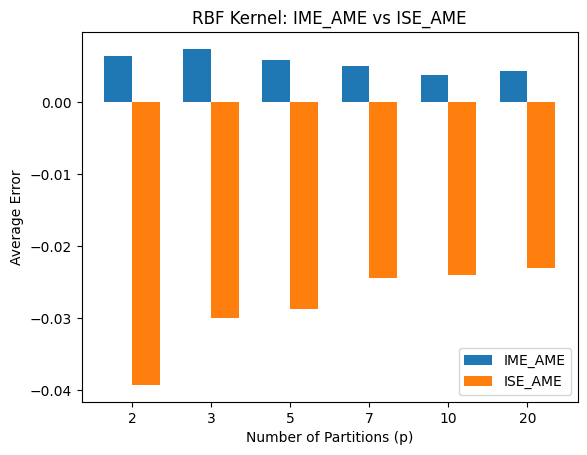

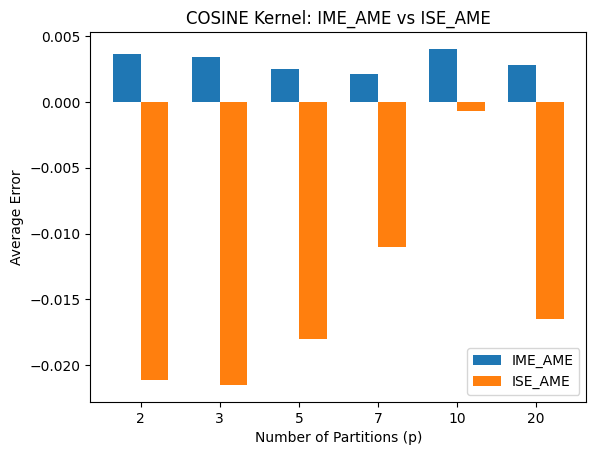

In [ ]:
import matplotlib.pyplot as plt

partitions = [2,3,5,7,10,20]
kernels = ['rbf','cosine']
avg_metrics = {k:{'IME_AME':[],'ISE_AME':[]} for k in kernels}

for k in kernels:
    for p in partitions:
        ime = [data[f'fold{i}_{k}_p{p}']['Result_train']['IME_AME'] for i in folds]
        ise = [data[f'fold{i}_{k}_p{p}']['Result_train']['ISE_AME'] for i in folds]
        avg_metrics[k]['IME_AME'].append(np.mean(ime))
        avg_metrics[k]['ISE_AME'].append(np.mean(ise))

for kernel in ['rbf', 'cosine']:
    ime = avg_metrics[kernel]['IME_AME']
    ise = avg_metrics[kernel]['ISE_AME']
    x = np.arange(len(partitions))
    width = 0.35

    fig, ax = plt.subplots()
    ax.bar(x - width/2, ime, width)
    ax.bar(x + width/2, ise, width)

    ax.set_xticks(x)
    ax.set_xticklabels(partitions)
    ax.set_xlabel('Number of Partitions (p)')
    ax.set_ylabel('Average Error')
    ax.set_title(f'{kernel.upper()} Kernel: IME_AME vs ISE_AME')
    ax.legend(['IME_AME', 'ISE_AME'])

    plt.show()

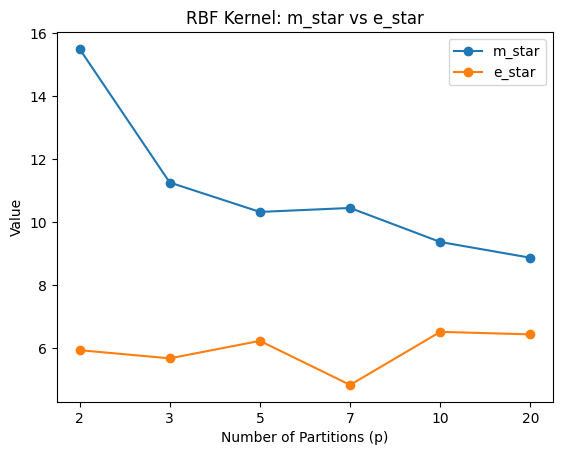

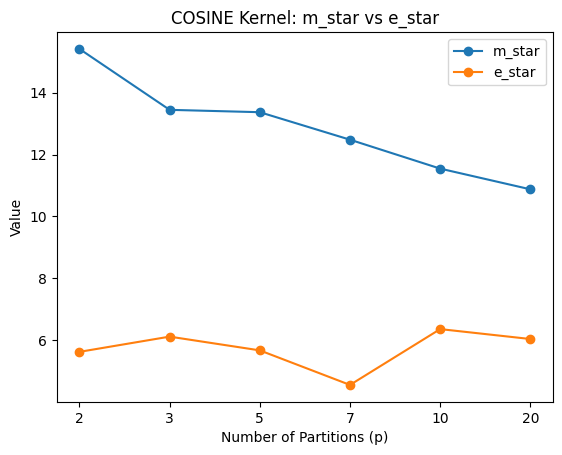

In [ ]:
partitions = [2, 3, 5, 7, 10, 20]
kernels = ['rbf', 'cosine']

# Compute average m_star and e_star across folds
avg_me = {k: {'m_star': [], 'e_star': []} for k in kernels}

for k in kernels:
    for p in partitions:
        m_vals, e_vals = [], []
        for fold in folds:
            m, e = data[f'fold{fold}_{k}_p{p}']['m_star, e_star']
            m_vals.append(m)
            e_vals.append(e)
        avg_me[k]['m_star'].append(np.mean(m_vals))
        avg_me[k]['e_star'].append(np.mean(e_vals))

# Plot for each kernel
for k in kernels:
    x = np.arange(len(partitions))
    fig, ax = plt.subplots()
    ax.plot(x, avg_me[k]['m_star'], marker='o')
    ax.plot(x, avg_me[k]['e_star'], marker='o')
    ax.set_xticks(x)
    ax.set_xticklabels(partitions)
    ax.set_xlabel('Number of Partitions (p)')
    ax.set_ylabel('Value')
    ax.set_title(f'{k.upper()} Kernel: m_star vs e_star')
    ax.legend(['m_star', 'e_star'])
    plt.show()

In [ ]:
avg_metrics = {k: {'IME_PEHE': [], 'ISE_PEHE': []} for k in kernels}

for k in kernels:
    for p in partitions:
        ime = [data[f'fold{i}_{k}_p{p}']['Result_train']['IME_PEHE'] for i in folds]
        ise = [data[f'fold{i}_{k}_p{p}']['Result_train']['ISE_PEHE'] for i in folds]
        print(ime)
        avg_metrics[k]['IME_PEHE'].append(np.mean(ime))
        avg_metrics[k]['ISE_PEHE'].append(np.mean(ise))

# Plot IME_PEHE vs ISE_PEHE
for kernel in ['rbf', 'cosine']:
    ime = avg_metrics[kernel]['IME_PEHE']
    ise = avg_metrics[kernel]['ISE_PEHE']
    x = np.arange(len(partitions))
    width = 0.35

    fig, ax = plt.subplots()
    ax.bar(x - width/2, ime, width)
    ax.bar(x + width/2, ise, width)

    ax.set_xticks(x)
    ax.set_xticklabels(partitions)
    ax.set_xlabel('Number of Partitions (p)')
    ax.set_ylabel('Average PEHE Error')
    ax.set_title(f'{kernel.upper()} Kernel: IME_PEHE vs ISE_PEHE')
    ax.legend(['IME_PEHE', 'ISE_PEHE'])

    plt.show()

NameError: name 'data' is not defined